In [1]:
# import packages

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx

from src import utils, figures, calculations, max_act_diff

### Example data

In [2]:
# Example Filters and Patients and Labels of whether they have a hip replacement (1) or not (0)

filters = np.array([[[[0, 0, 1], 
                    [0, 1, 0], 
                    [0, 0, 1]], [[1, 1, 0], 
                                 [0, 0, 0], 
                                 [0, 0, 0]]], 
                   [[[0, 1, 0], 
                    [0, 1, 0], 
                    [0, 0, 1]], [[1, 0, 0], 
                                 [0, 0, 0], 
                                 [0, 0, 0]]]])


input_tensors = np.array([[[[0, 0, 0], 
                          [0, 0, 3], 
                          [0, 0, 0]], [[0, 0, 0],
                                       [0, 0, 0],
                                       [0, 4, 4]], [[0, 0, 0], 
                                                    [0, 2, 0], 
                                                    [0, 2, 0]], [[0, 0, 0], 
                                                                 [5, 0, 5], 
                                                                 [0, 0, 0]]],                        
                        [[[1, 0, 0], 
                          [1, 0, 0], 
                          [1, 0, 0]], [[0, 0, 0],
                                       [0, 8, 0],
                                       [0, 0, 0]], [[0, 11, 0], 
                                                    [0, 0, 0], 
                                                    [0, 11, 0]], [[0, 0, 30], 
                                                                 [0, 0, 30], 
                                                                 [0, 0, 30]]],                       
                          
                          [[[0, 0, 9], 
                          [0, 0, 0], 
                          [0, 0, 0]], [[0, 0, 0],
                                       [7, 0, 0],
                                       [7, 0, 0]], [[0, 0, 0], 
                                                    [0, 0, 2], 
                                                    [0, 0, 0]], [[0, 0, 0], 
                                                                 [1, 0, 0], 
                                                                 [0, 0, 0]]],                          
                          [[[1, 1, 1], 
                          [0, 0, 0], 
                          [0, 0, 0]], [[0, 0, 1],
                                       [0, 0, 1],
                                       [0, 0, 0]], [[0, 0, 0], 
                                                    [0, 1, 0], 
                                                    [0, 1, 0]], [[0, 2, 0], 
                                                                 [0, 0, 0], 
                                                                 [0, 2, 0]]]]
                        
                        )


labels = [0, 1, 1, 0] #hip_replacement labels

### Calculate Maximum Activation Difference Between Hip Replacement and No Hip Replacement 

The maximum activation for patient 0 and filter 0 = 4
The maximum activation for patient 1 and filter 0 = 19
The maximum activation for patient 2 and filter 0 = 9
The maximum activation for patient 3 and filter 0 = 3
The maximum activation for patient 0 and filter 1 = 4
The maximum activation for patient 1 and filter 1 = 11
The maximum activation for patient 2 and filter 1 = 0
The maximum activation for patient 3 and filter 1 = 1
   Filter  Difference
0       1        10.5
1       2         3.0


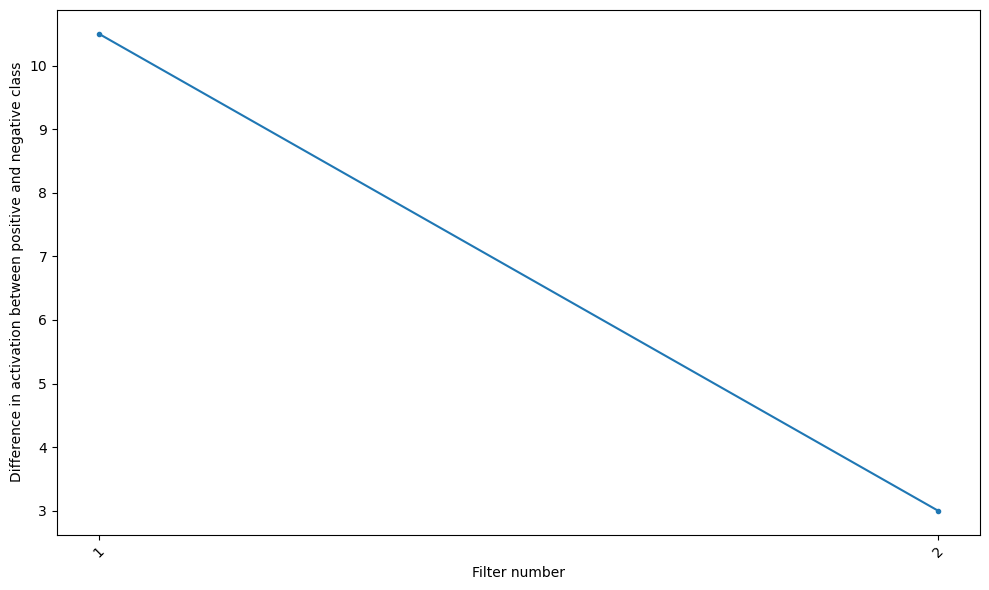

In [3]:
mean_activation_df = max_act_diff.max_act_diff_calc('Hip Replacement', input_tensors, filters, labels, verbose=True)

## Activation mapping graphs for edges

* Get the patient 'graph'
* Get the filter with the strongest differentiation of maximum activation
* Do element-wise multiplication between the filter and the patient graph
* Make the edges with zero activation grey
    * Where an edge is the x and y for each timestep.
    * A node is a new node even if the node has already been visited.
    * Nodes can be named e.g. r5_t1 (read code = 5, timestep = 1)
    * Use the element-wise ('activation') result to colour the edges red if the connection isn't zero.
    
Limitations:
* This method requires there to be no overlap in the CNN windows.

In [4]:
# COULD USE THESE ARRAYS FOR THE TEST

# Pick one patient graph to draw
patient_graph = input_tensors[0]
patient_graph

array([[[0, 0, 0],
        [0, 0, 3],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 4, 4]],

       [[0, 0, 0],
        [0, 2, 0],
        [0, 2, 0]],

       [[0, 0, 0],
        [5, 0, 5],
        [0, 0, 0]]])

In [5]:
max_act_filt = utils.get_max_act_filt(mean_activation_df, filters)

In [6]:
act_graph = calculations.get_act_graph_array(patient_graph, max_act_filt)
act_graph

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 2., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [7]:
edges_df = utils.create_edges_df(patient_graph, act_graph)
edges_df

,start_node,end_node,activated,weight,time_between
0,1_v0,2_v1,0,0.5,3
1,2_v1,1_v2,0,0.5,4
2,2_v1,2_v2,0,0.5,4
3,1_v2,1_v3,1,2.0,2
4,2_v2,1_v3,0,0.5,2
5,1_v3,0_v4,0,0.5,5
6,1_v3,2_v4,0,0.5,5


In [8]:
pos_df = utils.create_position_df(edges_df)

,node,x,cumulative_count,max_codes_per_visit
0,1_v0,0,0,1
1,2_v1,1,0,1
2,1_v2,2,0,2
3,2_v2,2,1,2
4,1_v3,3,0,1
5,0_v4,4,0,2
6,2_v4,4,1,2


In [9]:
def generate_pos_sequence(x):
    """
    Generate a list of lists to get y coordinate positions based on 
    the number of events recorded per visit.
    """
    sequence = []
    for i in range(x):
        if i % 2 == 0:  # Even index, include zero
            sequence.append(list(range(-i // 2, i // 2 + 1)))
        else:  # Odd index, exclude zero
            sublist = list(range(-(i // 2 + 1), i // 2 + 2))
            sublist.remove(0)
            sequence.append(sublist)
    return sequence


max_num_codes_per_visit = pos_df['max_codes_per_visit'].max()
pos_list = generate_pos_sequence(max_num_codes_per_visit)

# TODO: TEST - sublist for x should be...
print(pos_list)

[[0], [-1, 1]]


In [13]:
def get_pos_value(row):
    """
    Get the y position for the node. Use max_codes_per_visit to select the sublist and the 
    cumulative_count to get the position from the sublist.
    """
    cum_count = row['cumulative_count']
    max_codes = row['max_codes_per_visit']
    return pos_list[max_codes - 1][cum_count]

pos_df['y'] = pos_df.apply(get_pos_value, axis=1)

pos_df


,node,x,cumulative_count,max_codes_per_visit,y
0,1_v0,0,0,1,0
1,2_v1,1,0,1,0
2,1_v2,2,0,2,-1
3,2_v2,2,1,2,1
4,1_v3,3,0,1,0
5,0_v4,4,0,2,-1
6,2_v4,4,1,2,1


In [ ]:

# the visit number is x and the y value is the number of nodes with the same visit number
pos = pos_df.set_index('node')[['x', 'y']].apply(tuple, axis=1).to_dict()
pos

In [11]:
pos_df

,node,x,cumulative_count,max_codes_per_visit,y
0,1_v0,0,0,1,0
1,2_v1,1,0,1,0
2,1_v2,2,0,2,-1
3,2_v2,2,1,2,1
4,1_v3,3,0,1,0
5,0_v4,4,0,2,-1
6,2_v4,4,1,2,1


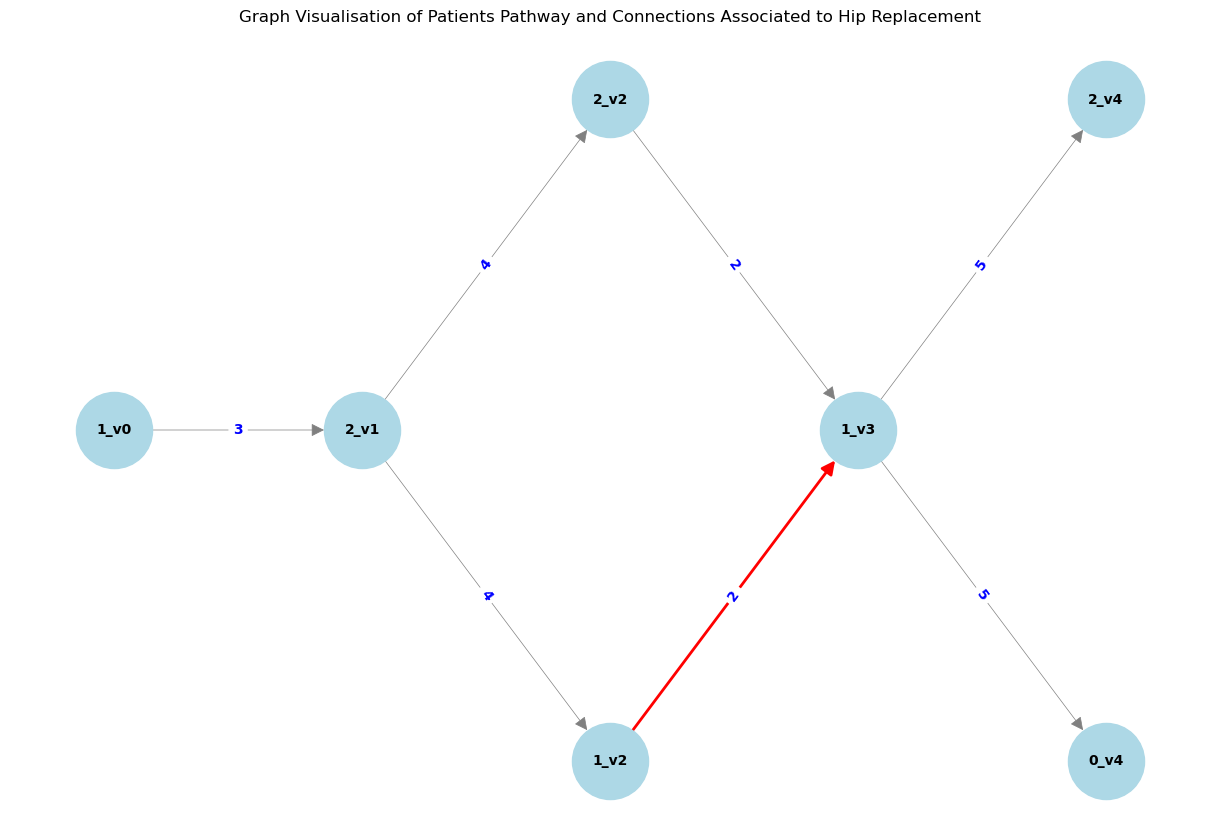

In [12]:
# Convert df to list of tuples for Networkx
edges = []
for _, row in edges_df.iterrows():
    edge = (row['start_node'], row['end_node'], {'activated': row['activated'], 'weight': row['weight'], 'edge_label': row['time_between']})
    edges.append(edge)


# edges = [
#     ('1_v0', '2_v1', {'activated': 0, 'weight': 0.5, 'edge_label': 3}),
#     ('2_v1', '1_v2', {'activated': 0, 'weight': 0.5, 'edge_label': 4}),
#     ('2_v1', '2_v2', {'activated': 0, 'weight': 0.5, 'edge_label': 4}),
#     ('1_v2', '1_v3', {'activated': 1, 'weight': 2, 'edge_label': 2}),
#     ('2_v2', '1_v3', {'activated': 0, 'weight': 0.5, 'edge_label': 2}),
#     ('1_v3', '0_v4', {'activated': 0, 'weight': 0.5, 'edge_label': 5}),
#     ('1_v3', '2_v4', {'activated': 0, 'weight': 0.5, 'edge_label': 5})
# ]


G = nx.DiGraph()


G.add_edges_from(edges)


# pos = {
#     '1_v0': (0, 0),
#     '2_v1': (1, 0),
#     '1_v2': (2, 1),
#     '2_v2': (2, -1),
#     '1_v3': (3, 0),
#     '0_v4': (4, 1),
#     '2_v4': (4, -1)
# }

# Prepare edge colors and widths based on attributes
edge_colors = ['red' if G[u][v]['activated'] == 1 else 'grey' for u, v in G.edges()]
edge_widths = [G[u][v]['weight'] for u, v in G.edges()]

# Draw the graph
plt.figure(figsize=(12, 8))

nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", edge_color=edge_colors, width=edge_widths, font_size=10, font_weight="bold", arrowsize=20)

edge_labels = {(u, v): G[u][v]['edge_label'] for u, v in G.edges()}

# Draw edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue', font_size=10, font_weight='bold')

plt.title("Graph Visualisation of Patients Pathway and Connections Associated to Hip Replacement")
plt.show()
